<a href="https://colab.research.google.com/github/ppareek/intro-to-data-visualization-Python-live-training/blob/master/IntroductoryNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Retrieve Data

# Predict the output of a continuous value using tf.keras API.

**Import Dependencies and Load Data**

In [109]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, time
from scipy.stats import linregress

In [110]:
df = pd.read_csv('/content/Dataset.csv', index_col='SampleId', parse_dates = ['Sample Date'])

## Review the code

In [111]:
df[df['Sample Date'] == '-'] = np.NaN
df[~df['Sample Date'].isna()]['Sample Date'].apply(lambda x: datetime.strptime(str(x), "%b %d/%y")).head()
df[(df['Sample Time'] == '-') | (df['Sample Time'] == 'nan')] = np.NaN
df[~df['Sample Time'].isna()]["Sample Time"].apply(lambda x: datetime.strptime(str(x),'%H:%M:%S'))

SampleId
E191601   1900-01-01 21:30:00
E191602   1900-01-01 21:30:00
E191603   1900-01-01 21:30:00
E191604   1900-01-01 21:30:00
E191605   1900-01-01 09:30:00
                  ...        
E196983   1900-01-01 23:30:00
E196984   1900-01-01 23:30:00
E196985   1900-01-01 23:30:00
E196987   1900-01-01 07:30:00
E196988   1900-01-01 07:30:00
Name: Sample Time, Length: 752, dtype: datetime64[ns]

In [112]:
df["DateTime"] = df["Sample Date"] + " " + df["Sample Time"]
df = df.astype({"DateTime": 'datetime64[ns]', "Sample Date": 'datetime64[ns]'})

In [113]:
df.drop(columns = {"Sample Time"}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 762 entries, E191601 to E196988
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PlantId           755 non-null    object        
 1   Train             217 non-null    object        
 2   Sample Date       755 non-null    datetime64[ns]
 3   Lab Comments_TLX  285 non-null    object        
 4   MASS_BAL          755 non-null    float64       
 5   %_BITUMEN         755 non-null    float64       
 6   %_WATER           755 non-null    float64       
 7   %_SOLIDS          755 non-null    float64       
 8   SAMPLE_WT         755 non-null    float64       
 9   Technique         755 non-null    object        
 10  Lab Comments_CPA  23 non-null     object        
 11  DIA_0.04          755 non-null    float64       
 12  DIA_0.06          755 non-null    float64       
 13  DIA_0.100         755 non-null    float64       
 14  DIA_0.130         755

# Create Training and Validation Datasets

Create dataframe with absolute weights for each 

In [114]:
def get_cpa_absolute_results(input_dataframe):
  """
  Extracts the cpa columns from the dataset and calculates the absolute percentage
  of particles in each bin.
  """
  df = input_dataframe
  cpaDf = df[df.columns[df.columns.str.contains(pat="DIA_")]].copy()
  cpaCols = df.columns[df.columns.str.contains(pat="DIA_")]
  cpaDf.columns = [col.replace("DIA_", "") for col in cpaCols]
  dfCpaResults = pd.DataFrame(cpaDf.iloc[:,0])
  #cpaBin22Value = cpaDf["22.00"]
  
  for i in range(cpaDf.shape[1]  - 1):
    diffSeries = cpaDf.iloc[:, i + 1 ].subtract(cpaDf.iloc[:, i])
    #diffSeries = cpaDf.iloc[:, i + 1 ].subtract(cpaBin22Value)
    diffSeries.name = cpaDf.columns[i+1]
    dfCpaResults = pd.concat([dfCpaResults , diffSeries], axis = 1)
  dfCpaResults = pd.concat([df["Sample Date"],  dfCpaResults], axis = 1)
  #dfCpaResults["22.00"] = cpaBin22Value
  return dfCpaResults

In [115]:
def preprocess_features(cpadata):
  """retrieve all the cpa columns that are to be used as features.

  Args:
      cpa_results_dataframe: DF with CPA results per sample.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    derived features.
  """
  start_index = cpadata.columns.get_loc("31.00")
  return cpadata.iloc[:,start_index:].copy()

In [116]:
def preprocess_targets(cpadata):
  """Prepares target feature (i.e., labels) from cpa results data set.

  Args:
    cpadata: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  endIndex = cpadata.columns.get_loc("22.00")
  valuesLessEqual22  = cpadata.iloc[:, :endIndex + 1]
  output_targets["LessThanEqualTo22"] = valuesLessEqual22.sum(axis = 1)
  return output_targets

In [117]:
def preprocess_targets_old(cpaData):
  output_targets = pd.DataFrame()
  #endIndex = cpaData.columns.get_loc("22.00")
  output_targets["LessThanEqualTo22"] = cpaData["22.00"]
  return output_targets

In [118]:
cpa_results = get_cpa_absolute_results(df)
print(cpa_results[cpa_results["22.00"].isna()])
print(validation_targets.head())


         Sample Date  0.04  0.06  0.100  0.130  ...  360.0  500.0  720.0  1000  1440
SampleId                                        ...                                 
E191805          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN
E191806          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN
E191807          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN
E196914          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN
E196915          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN
E196916          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN
E196986          NaT   NaN   NaN    NaN    NaN  ...    NaN    NaN    NaN   NaN   NaN

[7 rows x 32 columns]
          LessThanEqualTo22
SampleId                   
E191601               22.28
E191602               26.60
E191603               24.23
E191604               24.32
E191605               16.82


## Split into test and training datasets

In [119]:
gp = df.groupby(['Sample Date'])
random.seed(1) 
dates  = list(gp.groups.keys())
datesRandomized = random.sample(dates, len(dates)) # shuffles the dates and returns a new list

In [120]:
import math
trainingCount = math.floor(0.7 * len(datesRandomized))
trainingDates = datesRandomized[:trainingCount + 1]
validationDates = datesRandomized[trainingCount + 1:]

In [121]:
print(df[df["Sample Date"].dt.date.isin([i.date() for i in trainingDates])])
print(df[df["Sample Date"].dt.date.isin([i.date() for i in validationDates])])

         PlantId Train Sample Date  ...    FinesWt  SToFRatio            DateTime
SampleId                            ...                                          
E191601     5153   NaN  2016-12-05  ...  20.720596   3.681885 2016-12-05 21:30:00
E191602     5353   NaN  2016-12-05  ...  23.026505   3.119152 2016-12-05 21:30:00
E191603     5553   NaN  2016-12-05  ...  16.669632   3.415301 2016-12-05 21:30:00
E191604     5653   NaN  2016-12-05  ...  11.150666   3.481894 2016-12-05 21:30:00
E191605     5153   NaN  2016-12-06  ...  10.663107   4.833253 2016-12-06 09:30:00
...          ...   ...         ...  ...        ...        ...                 ...
E196976     5353   NaN  2017-03-29  ...   3.098035   3.105590 2017-03-29 11:30:00
E196977     5453   NaN  2017-03-29  ...   3.803237   4.578755 2017-03-29 11:30:00
E196978     5153   NaN  2017-03-29  ...   2.311570   7.668712 2017-03-29 21:30:00
E196979     5353   NaN  2017-03-29  ...   1.432836   4.967710 2017-03-29 21:30:00
E196980     5453

In [122]:
cpa_results =  get_cpa_absolute_results(df)

trainingSet = cpa_results[cpa_results["Sample Date"].dt.date.isin([i.date() for i in trainingDates])].copy().drop(columns = ['Sample Date'])
trainingSet.to_csv("TrainingSet.csv")
print("Training Row Count : " +  str(trainingSet.shape[0]))
validationSet = cpa_results[cpa_results["Sample Date"].dt.date.isin([i.date() for i in validationDates])].copy().drop(columns = ['Sample Date'])
validationSet.to_csv("ValidationSet.csv")
print("Validation Row Count : " +  str(validationSet.shape[0]))

Training Row Count : 527
Validation Row Count : 228


In [123]:
training_examples = preprocess_features(trainingSet)
training_targets = preprocess_targets(trainingSet)

validation_examples = preprocess_features(validationSet)
validation_targets = preprocess_targets(validationSet)

In [124]:
# Double-check that we've done the right thing.
print("Training examples summary:")
print(training_examples.describe())
print("Validation examples summary:")
print(validation_examples.describe())

print("Training targets summary:")
print(training_targets.describe())
print("Validation targets summary:")
print(validation_targets.describe())
print(validation_targets.info())

print(training_targets.info())
print(validation_targets.info())

Training examples summary:
            31.00       44.00       62.00  ...       720.0        1000        1440
count  527.000000  527.000000  527.000000  ...  527.000000  527.000000  527.000000
mean     2.050626    2.641157    3.491708  ...    0.720512    0.059943    0.002808
std      0.693090    0.830525    0.971304  ...    1.218201    0.196122    0.053038
min      0.700000    1.080000    0.480000  ...    0.000000    0.000000    0.000000
25%      1.670000    2.140000    2.845000  ...    0.000000    0.000000    0.000000
50%      1.980000    2.560000    3.360000  ...    0.000000    0.000000    0.000000
75%      2.330000    2.960000    3.995000  ...    1.275000    0.020000    0.000000
max      5.870000    7.510000    7.890000  ...    7.650000    2.540000    1.200000

[8 rows x 12 columns]
Validation examples summary:
            31.00       44.00       62.00  ...       720.0        1000        1440
count  228.000000  228.000000  228.000000  ...  228.000000  228.000000  228.000000
mean    

# Check Requirements for model building

In [125]:
!pip install seaborn
!pip install gast==0.2.2

In [126]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
%matplotlib inline
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

#Neural Network

Building a Neural Network
The NN is defined by the DNNRegressor class.

Use hidden_units to define the structure of the NN. The hidden_units argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it. For example, consider the following assignment:

hidden_units=[3,10]

The preceding assignment specifies a neural net with two hidden layers:

The first hidden layer contains 3 nodes.
The second hidden layer contains 10 nodes.
If we wanted to add more layers, we'd add more ints to the list. For example, hidden_units=[10,20,30,40] would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [127]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [128]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [129]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 20
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["LessThanEqualTo22"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["LessThanEqualTo22"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["LessThanEqualTo22"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

In [130]:
#validation_predictions.head()
validation_targets.head()

,LessThanEqualTo22
SampleId,
E191624,19.43
E191625,19.31
E191626,12.92
E191627,15.10
E191628,13.74


## Task 1: Train a NN Model
**Adjust hyperparameters**

Run the following block to train a NN model.  

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


Training model...
RMSE (on training data):
  period 00 : 10.51
  period 01 : 10.06
  period 02 : 9.85
  period 03 : 9.53
  period 04 : 9.43
  period 05 : 9.98
  period 06 : 9.01
  period 07 : 8.79
  period 08 : 9.11
  period 09 : 9.97
  period 10 : 10.97
  period 11 : 10.26
  period 12 : 8.22
  period 13 : 8.10
  period 14 : 7.80
  period 15 : 9.17
  period 16 : 8.78
  period 17 : 7.47
  period 18 : 7.32
  period 19 : 7.23
Model training finished.
Final RMSE (on training data):   7.23
Final RMSE (on validation data): 9.43


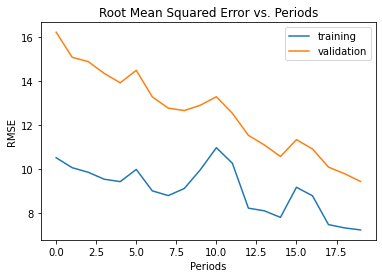

In [131]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

[]

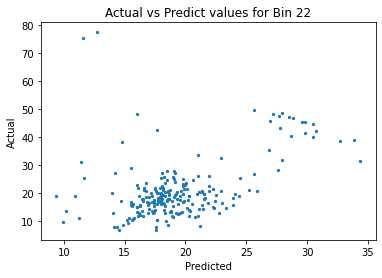

In [132]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["LessThanEqualTo22"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

plt.scatter(validation_predictions, validation_targets,s=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predict values for Bin 22")
   
#slope, intercept, r_value, p_value, std_err = linregress(validation_predictions, validation_targets.to_numpy())
#print("Validation predictions r_value**2 : %0.2f" % r_value**2  )

plt.plot()

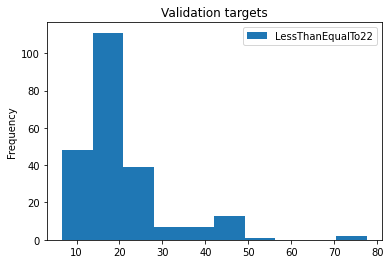

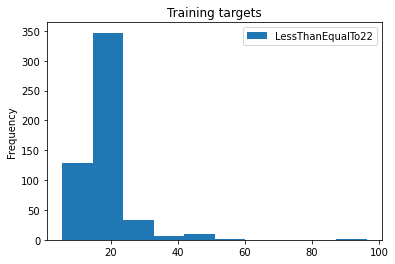

In [133]:
validation_targets.plot(kind = 'hist', bins = 10, title="Validation targets")
training_targets.plot(kind = 'hist', bins = 10, title="Training targets")